## Script que faz clustering com K-Means

O **K-Means** é um algoritmo de agrupamento não supervisionado que divide os dados em **k clusters** com base na proximidade aos **centroides**, que representam a média dos pontos em cada cluster. Ele alterna entre atribuir pontos ao cluster mais próximo e recalcular os centroides até convergir. Simples e eficiente, o K-Means é amplamente usado em segmentação de clientes, análise de padrões e agrupamento de documentos. Sua principal desvantagem é a necessidade de definir previamente o número de clusters (**k**) e sua sensibilidade a outliers.

Este script irá testar diferentes números de clusters para identificar a quantidade que gera a melhor **compactação**, **separação** e **coerência** dos grupos formados. A avaliação será realizada utilizando as métricas:

- **Silhouette Score:** Mede a compactação dentro dos clusters e a separação entre clusters.
- **Davies-Bouldin Score:** Avalia a relação entre a dispersão dentro dos clusters e a separação entre clusters (valores menores indicam melhor qualidade).
- **Calinski-Harabasz Score:** Mede a proporção entre a variância entre clusters e dentro dos clusters (valores maiores indicam melhor qualidade).

Adicionalmente, o teste levará em consideração:
- A análise com o texto original e o texto tratado.
- A aplicação de métodos de redução de dimensionalidade para otimizar os dados.

---

**1)** Execução Inicial:
O script inicia com a leitura do arquivo:  
**`/saida/05_DOU2_portarias_mgi_tratado_NER_lematizado_embeddingsUSE_SBERT_Reducao.parquet`**  
Caso este arquivo não exista, executar o notebook **`05_ReducaoDimensionalidade.ipynb`** para gerar os dados necessários.



## Bibliotecas

In [1]:
# Bibliotecas para manipulação de dados e cálculo
import pandas as pd
import numpy as np
import time  # Para medir o tempo de execução

# Bibliotecas para visualização
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Bibliotecas para clusterização
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
import hdbscan

# Bibliotecas de aprendizado de máquina e redução de dimensionalidade
from sklearn.decomposition import PCA, KernelPCA
# from sklearn.manifold import TSNE, LocallyLinearEmbedding
# from sklearn.preprocessing import StandardScaler
# import umap

# Métricas para avaliação de clusters
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Hierarquia para dendrogramas
from scipy.cluster.hierarchy import dendrogram, linkage


In [2]:
douItem = 2
secao = f'Secao0{douItem}'

# Lê o arquivo Parquet
df_portarias_mgi = pd.read_parquet(f'./saida/05_DOU{secao}_portarias_mgi_tratado_NER_lematizado_embeddingsUSE_SBERT_Reducao.parquet', engine='pyarrow')  # ou engine='fastparquet'

# Exibe as primeiras linhas do DataFrame
df_portarias_mgi.shape


(19258, 63)

In [3]:
df_portarias_mgi.head()

,id,name,idOficio,pubName,artType,pubDate,artClass,artCategory,artSize,artNotes,...,SBERT_Embeddings1_KPCA,SBERT_Embeddings4_KPCA,USE_Embeddings1_PCA_TSNE,USE_Embeddings4_PCA_TSNE,SBERT_Embeddings1_PCA_TSNE,SBERT_Embeddings4_PCA_TSNE,USE_Embeddings1_UMAP,USE_Embeddings4_UMAP,SBERT_Embeddings1_UMAP,SBERT_Embeddings4_UMAP
0,30266027,PORTARIA DE PESSOAL 529,9368436,DO2,Portaria,2023-01-25,00028:00006:00000:00000:00000:00000:00000:0000...,Ministério da Gestão e da Inovação em Serviços...,12,,...,"[0.016321918, 0.07024405]","[0.014584291, 0.04337406]","[-16.726706, 56.970505]","[13.92976, -91.40009]","[0.7567154, -73.164856]","[6.9597764, -70.976524]","[13.159501, 2.6076024]","[-2.5174575, -2.1294782]","[2.8837821, -5.633801]","[4.4205976, 5.3656497]"
1,30264410,ATO PORTARIA 655,9368530,DO2,Portaria,2023-01-25,00028:00006:00000:00000:00000:00000:00000:0000...,Ministério da Gestão e da Inovação em Serviços...,12,,...,"[0.008526144, 0.009507837]","[-0.026086908, -0.073050216]","[-39.248245, 74.718]","[-31.301977, -77.763405]","[-8.304266, -38.56507]","[23.96577, -36.566616]","[8.013924, 7.6135964]","[0.0643677, -4.1535616]","[14.249727, 4.997593]","[2.3798013, 6.2923975]"
2,30265009,ATO PORTARIA DE PESSOAL 461,9368536,DO2,Portaria,2023-01-25,00028:00006:00000:00000:00000:00000:00000:0000...,Ministério da Gestão e da Inovação em Serviços...,12,,...,"[0.00028666237, 0.04367776]","[-0.027844444, -0.11997401]","[-39.27794, 74.63971]","[-31.275515, -77.7285]","[-5.679678, -33.73889]","[22.499407, -35.780396]","[8.013194, 7.5345373]","[0.16797487, -4.068984]","[14.227807, 4.8963118]","[2.4286757, 6.2753396]"
3,30265678,ATO PORTARIA DE PESSOAL SGP 606,9368541,DO2,Portaria,2023-01-25,00028:00006:00000:00000:00000:00000:00000:0000...,Ministério da Gestão e da Inovação em Serviços...,12,,...,"[-0.004174391, -0.0033765337]","[0.052405372, 0.034986008]","[-3.7416568, 82.783745]","[-68.57696, -53.742702]","[22.567476, 19.76176]","[-38.07335, 68.46514]","[2.7796974, 17.19619]","[-1.9187229, 1.1268833]","[5.586001, -7.525508]","[9.81046, -1.9470464]"
4,30266030,ATO PORTARIA DE PESSOAL SGP 517,9368573,DO2,Portaria,2023-01-25,00028:00006:00000:00000:00000:00000:00000:0000...,Ministério da Gestão e da Inovação em Serviços...,12,,...,"[-0.033022135, 0.040824868]","[-0.025164582, -0.046749085]","[7.020233, 100.1161]","[-52.336796, -65.22195]","[-30.662586, 61.111652]","[-31.004364, 59.990433]","[3.7728927, 16.399258]","[-0.9259139, 2.12552]","[5.687525, -7.678718]","[9.465585, -2.4269261]"


In [4]:
df_portarias_mgi.columns

Index(['id', 'name', 'idOficio', 'pubName', 'artType', 'pubDate', 'artClass',
       'artCategory', 'artSize', 'artNotes', 'numberPage', 'pdfPage',
       'editionNumber', 'highlightType', 'highlightPriority', 'highlight',
       'highlightimage', 'highlightimagename', 'idMateria', 'Identifica',
       'Data', 'Ementa', 'Titulo', 'SubTitulo', 'TextoHTML', 'file_name',
       'zip_name', 'Ano', 'Mes', 'Texto', 'Total_palavras', 'TextoTratado',
       'TextoTratado_TotalPalavras', 'Texto_sem_nomes', 'Nomes',
       'TextoTratadoSemNomes', 'TextoTratadoSemNomes_TotalPalavras',
       'TextoTratadoSemNomesLemmatized',
       'TextoTratadoSemNomesLemmatized_TotalPalavras', 'USE_Embeddings1',
       'USE_Embeddings4', 'SBERT_Embeddings1', 'SBERT_Embeddings4',
       'USE_Embeddings1_PCA', 'USE_Embeddings4_PCA', 'SBERT_Embeddings1_PCA',
       'SBERT_Embeddings4_PCA', 'USE_Embeddings1_TSNE', 'USE_Embeddings4_TSNE',
       'SBERT_Embeddings1_TSNE', 'SBERT_Embeddings4_TSNE',
       'USE_Embeddi

## Funções

In [5]:
def processar_kmeans(df, coluna, k_min=2, k_max=10):
    """
    Executa K-Means em uma coluna de embeddings e retorna as métricas de clusterização.

    Parâmetros:
        df (pd.DataFrame): DataFrame contendo os dados.
        coluna (str): Nome da coluna com os embeddings (array).
        k_min (int): Número mínimo de clusters a testar.
        k_max (int): Número máximo de clusters a testar.
    
    Retorno:
        pd.DataFrame: DataFrame com as métricas Silhouette, Davies-Bouldin e Calinski-Harabasz para cada k.
    """
    embeddings = np.vstack(df[coluna])

    # Faixa de valores de k
    k_values = range(k_min, k_max + 1)
    resultados = []

    for k in k_values:
        
        # Aplicar K-Means
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(embeddings)

        # Calcular métricas
        silhouette = silhouette_score(embeddings, labels)
        davies_bouldin = davies_bouldin_score(embeddings, labels)
        calinski_harabasz = calinski_harabasz_score(embeddings, labels)

        # Armazenar os resultados
        resultados.append({
            'k': k,
            'Silhouette Score': silhouette,
            'Davies-Bouldin Score': davies_bouldin,
            'Calinski-Harabasz Score': calinski_harabasz
        })

    # Converter para DataFrame
    df_resultados = pd.DataFrame(resultados)
    
    return df_resultados


In [6]:
def clusterizar_e_plotar(df, coluna, n_clusters, sufixo_coluna="kmeans", sufixo_grafico=""):
    """
    Realiza a clusterização com K-Means para uma coluna de embeddings, exibe métricas de avaliação,
    gera gráficos apropriados dependendo do número de dimensões dos embeddings, e retorna o DataFrame
    com uma nova coluna indicando os clusters.

    Parâmetros:
        df (pd.DataFrame): DataFrame contendo os dados.
        coluna (str): Nome da coluna com os embeddings (array).
        n_clusters (int): Número de clusters para o K-Means.
        sufixo_coluna (str): Sufixo a ser acrescentado ao nome da nova coluna.
        sufixo_grafico (str): Sufixo a ser incluído no título do gráfico, se fornecido.

    Retorno:
        pd.DataFrame: DataFrame com uma nova coluna contendo os clusters atribuídos.
    """
    # Extração dos embeddings
    embeddings = np.vstack(df[coluna])
    n_dimensoes = embeddings.shape[1]
    print(f'Dimensões do embeddings: {n_dimensoes}')
    
    # Clusterização com K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(embeddings)
    
    # Adicionar os clusters ao DataFrame
    cluster_column_name = f"{coluna}_{sufixo_coluna}"
    df[cluster_column_name] = clusters

    # Calcular métricas de avaliação
    silhouette = silhouette_score(embeddings, clusters)
    davies_bouldin = davies_bouldin_score(embeddings, clusters)
    calinski_harabasz = calinski_harabasz_score(embeddings, clusters)
    print("\n--- Métricas de Avaliação ---")
    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"Davies-Bouldin Score: {davies_bouldin:.4f}")
    print(f"Calinski-Harabasz Score: {calinski_harabasz:.4f}")
    print("-----------------------------\n")

    # Redução dimensional com PCA se necessário
    if n_dimensoes > 2:
        print(f"Reduzindo as dimensões para 2 com PCA para visualização (original: {n_dimensoes} dimensões)...")
        pca = PCA(n_components=2)
        embeddings_2d = pca.fit_transform(embeddings)
        centroids_2d = pca.transform(kmeans.cluster_centers_)
    else:
        embeddings_2d = embeddings
        centroids_2d = kmeans.cluster_centers_

    # Gerar gráfico
    print("Gerando gráfico 2D...")
    plt.figure(figsize=(10, 6))
    for cluster in range(n_clusters):
        cluster_points = embeddings_2d[clusters == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')
    plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], s=300, c='black', marker='X', label='Centroides')
    plt.xlabel('Dimensão 1' if n_dimensoes == 2 else 'Componente Principal 1')
    plt.ylabel('Dimensão 2' if n_dimensoes == 2 else 'Componente Principal 2')
    
    # Adicionar sufixo ao título do gráfico, se fornecido
    grafico_titulo = f"Clusterização com K-Means (k={n_clusters})"
    if sufixo_grafico:
        grafico_titulo = f"Clusterização com K-Means (k={n_clusters}) - {sufixo_grafico}"
    plt.title(grafico_titulo)
    
    plt.legend()
    plt.grid()
    plt.show()

    # Retornar o DataFrame atualizado
    return df


## 1) Embedding Universal Sentence Encoder (USE)

###  1.1) Sem tratamento do texto

#### 1.1.1) Sem redução de dimensionalidade

In [7]:
resultado_kmeans = processar_kmeans(df_portarias_mgi, 'USE_Embeddings1', k_min=2, k_max=10)

# Exibir os resultados
resultado_kmeans.head(100)

,k,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
0,2,0.139416,2.451478,2856.317627
1,3,0.143719,2.622350,2214.684082
2,4,0.122158,2.413978,1684.360229
3,5,0.134075,2.798971,1584.847168
4,6,0.127101,2.604230,1588.296021
5,7,0.126748,2.422355,1464.266235
6,8,0.120057,2.544636,1379.171143
7,9,0.120398,2.549300,1281.408203
8,10,0.126361,2.613453,1204.827393


Dimensões do embeddings: 512

--- Métricas de Avaliação ---
Silhouette Score: 0.1394
Davies-Bouldin Score: 2.4515
Calinski-Harabasz Score: 2856.3176
-----------------------------

Reduzindo as dimensões para 2 com PCA para visualização (original: 512 dimensões)...
Gerando gráfico 2D...


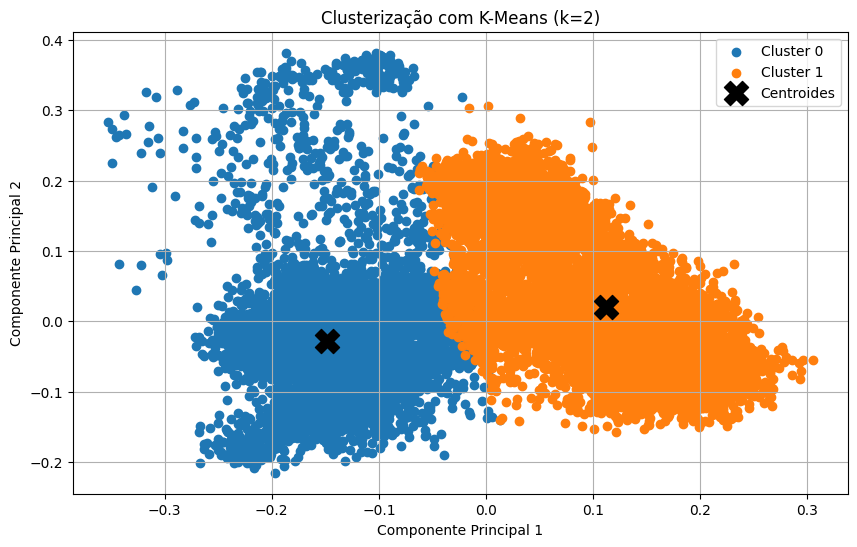

In [8]:
df_portarias_mgi = clusterizar_e_plotar(df_portarias_mgi, 'USE_Embeddings1', n_clusters=2)

#### 1.1.2) Redução com PCA

In [9]:
resultado_kmeans = processar_kmeans(df_portarias_mgi, 'USE_Embeddings1_PCA', k_min=2, k_max=10)

# Exibir os resultados
resultado_kmeans.head(100)

,k,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
0,2,0.535128,0.734718,24556.466797
1,3,0.604350,0.575668,38236.160156
2,4,0.495336,0.819192,31129.699219
3,5,0.494161,0.805325,30363.806641
4,6,0.487980,0.770381,31138.873047
5,7,0.430420,0.800954,32794.257812
6,8,0.395879,0.856404,31936.869141
7,9,0.387218,0.863843,30895.880859
8,10,0.384992,0.861625,30421.238281


Dimensões do embeddings: 2

--- Métricas de Avaliação ---
Silhouette Score: 0.6044
Davies-Bouldin Score: 0.5757
Calinski-Harabasz Score: 38236.1602
-----------------------------

Gerando gráfico 2D...


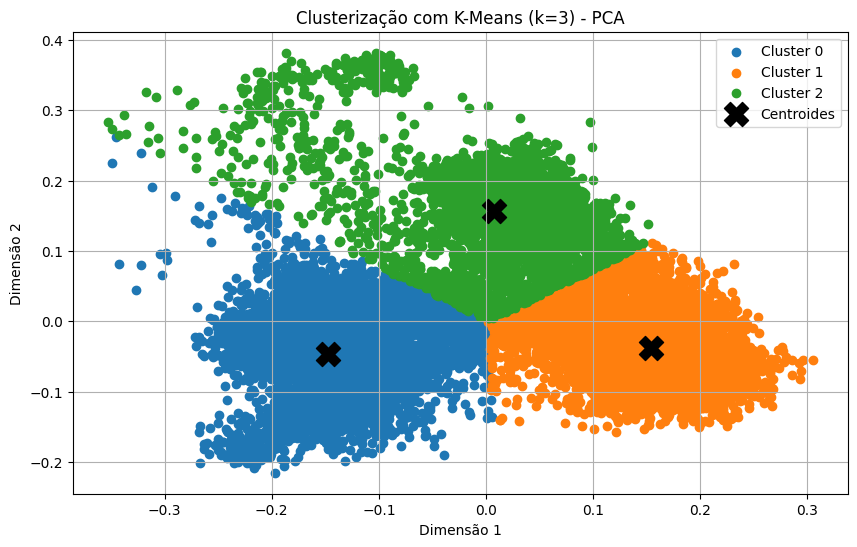

In [10]:
df_portarias_mgi = clusterizar_e_plotar(df_portarias_mgi, 'USE_Embeddings1_PCA', n_clusters=3, sufixo_grafico="PCA")

#### 1.1.3) Redução com t-SNE

In [11]:
resultado_kmeans = processar_kmeans(df_portarias_mgi, 'USE_Embeddings1_TSNE', k_min=2, k_max=10)

# Exibir os resultados
resultado_kmeans.head(100)

,k,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
0,2,0.345332,1.208877,11080.248047
1,3,0.383206,0.860522,15094.016602
2,4,0.381250,0.818526,17054.289062
3,5,0.372615,0.839209,17063.724609
4,6,0.389500,0.756909,17296.412109
5,7,0.370354,0.823377,16686.978516
6,8,0.374901,0.819068,17625.205078
7,9,0.373881,0.832835,17317.373047
8,10,0.377328,0.816816,17147.931641


Dimensões do embeddings: 2

--- Métricas de Avaliação ---
Silhouette Score: 0.3895
Davies-Bouldin Score: 0.7569
Calinski-Harabasz Score: 17296.4121
-----------------------------

Gerando gráfico 2D...


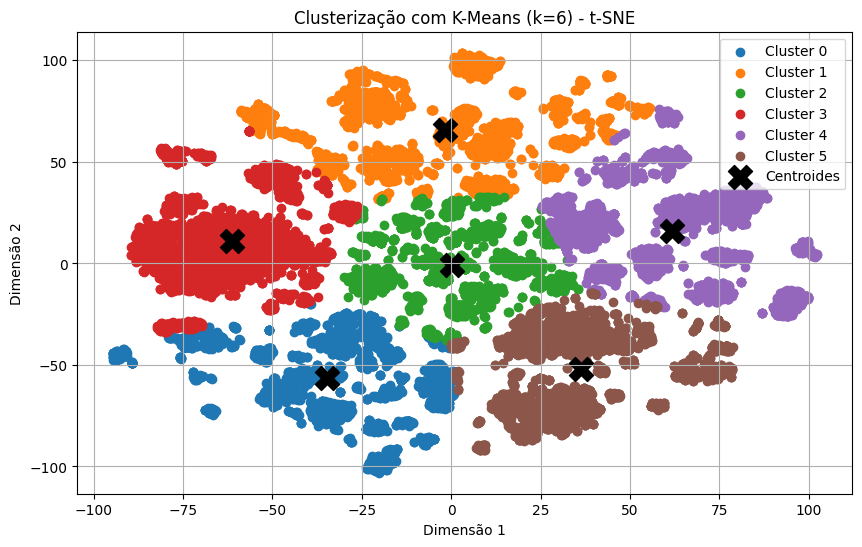

In [12]:
df_portarias_mgi = clusterizar_e_plotar(df_portarias_mgi, 'USE_Embeddings1_TSNE', n_clusters=6, sufixo_grafico="t-SNE")

#### 1.1.4) Redução com PCA + t-SNE

In [13]:
resultado_kmeans = processar_kmeans(df_portarias_mgi, 'USE_Embeddings1_PCA_TSNE', k_min=2, k_max=10)

# Exibir os resultados
resultado_kmeans.head(100)

,k,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
0,2,0.347610,1.204008,11207.115234
1,3,0.383359,0.851671,15014.272461
2,4,0.364279,0.830597,15841.208984
3,5,0.350631,0.919937,14319.015625
4,6,0.394210,0.767057,17415.582031
5,7,0.396008,0.765829,18235.396484
6,8,0.377320,0.827874,17906.927734
7,9,0.379384,0.815871,17691.939453
8,10,0.382835,0.823801,17860.392578


Dimensões do embeddings: 2

--- Métricas de Avaliação ---
Silhouette Score: 0.3960
Davies-Bouldin Score: 0.7658
Calinski-Harabasz Score: 18235.3965
-----------------------------

Gerando gráfico 2D...


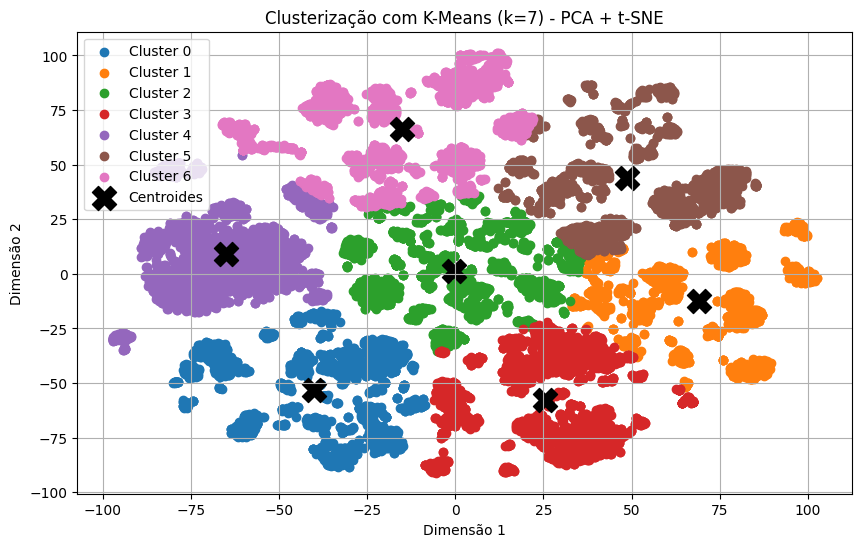

In [14]:
df_portarias_mgi = clusterizar_e_plotar(df_portarias_mgi, 'USE_Embeddings1_PCA_TSNE', n_clusters=7, sufixo_grafico="PCA + t-SNE")

#### 1.1.5) Redução com UMAP

In [15]:
resultado_kmeans = processar_kmeans(df_portarias_mgi, 'USE_Embeddings1_UMAP', k_min=2, k_max=10)

# Exibir os resultados
resultado_kmeans.head(100)

,k,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
0,2,0.417518,0.957635,16415.113281
1,3,0.421983,0.880629,18119.169922
2,4,0.410091,0.825023,17751.054688
3,5,0.399045,0.829934,18278.107422
4,6,0.430706,0.798712,18952.423828
5,7,0.460518,0.775066,20214.218750
6,8,0.446816,0.797960,19518.664062
7,9,0.469945,0.785037,21298.716797
8,10,0.474654,0.759495,22168.458984


Dimensões do embeddings: 2

--- Métricas de Avaliação ---
Silhouette Score: 0.4747
Davies-Bouldin Score: 0.7595
Calinski-Harabasz Score: 22168.4590
-----------------------------

Gerando gráfico 2D...


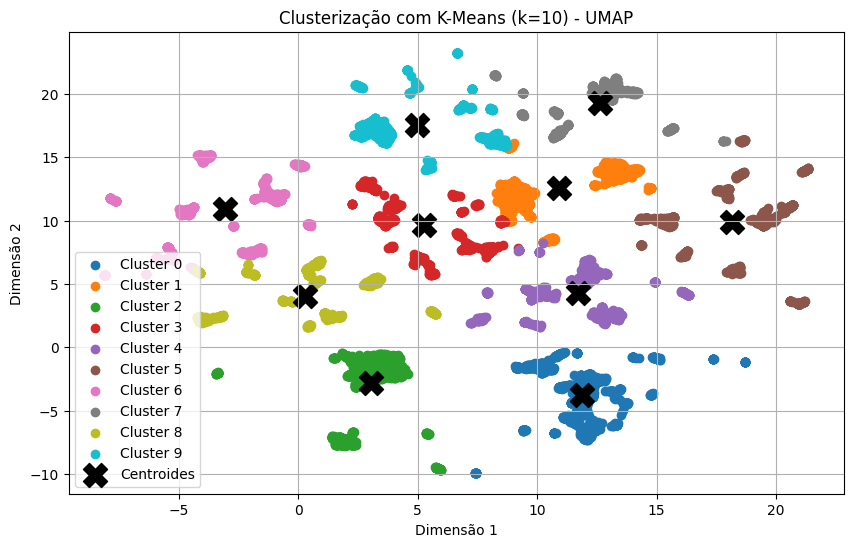

In [16]:
df_portarias_mgi = clusterizar_e_plotar(df_portarias_mgi, 'USE_Embeddings1_UMAP', n_clusters=10, sufixo_grafico="UMAP")

###  1.2) Com tratamento do texto

#### 1.2.1) Sem redução de dimensionalidade

In [17]:
resultado_kmeans = processar_kmeans(df_portarias_mgi, 'USE_Embeddings4', k_min=2, k_max=10)

# Exibir os resultados
resultado_kmeans.head(100)

,k,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
0,2,0.135134,2.547907,2763.725586
1,3,0.147195,2.595372,2392.196777
2,4,0.135291,2.610593,1684.002319
3,5,0.120772,2.368265,1702.836426
4,6,0.137265,2.357920,1675.196777
5,7,0.117755,2.445586,1486.681763
6,8,0.135906,2.808356,1439.204834
7,9,0.138768,2.642364,1341.204590
8,10,0.149609,2.535234,1257.564331


Dimensões do embeddings: 512

--- Métricas de Avaliação ---
Silhouette Score: 0.1208
Davies-Bouldin Score: 2.3683
Calinski-Harabasz Score: 1702.8364
-----------------------------

Reduzindo as dimensões para 2 com PCA para visualização (original: 512 dimensões)...
Gerando gráfico 2D...


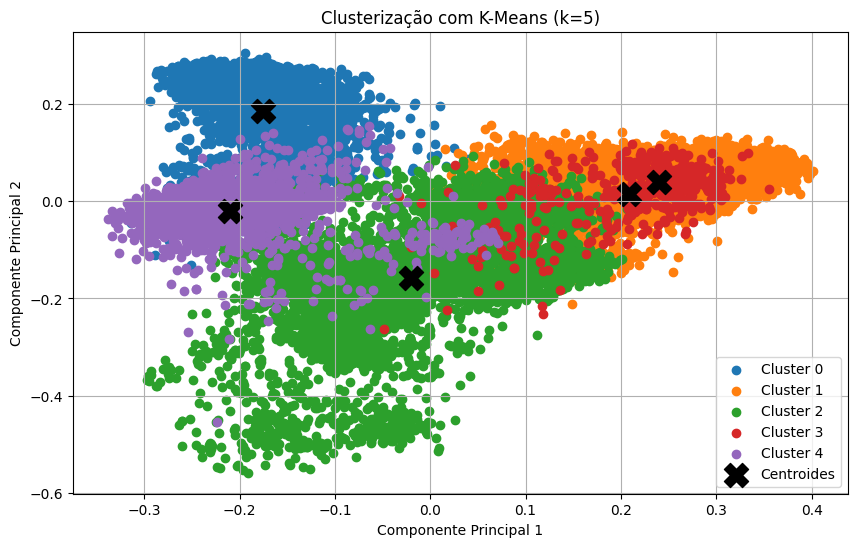

In [18]:
df_portarias_mgi = clusterizar_e_plotar(df_portarias_mgi, 'USE_Embeddings4', n_clusters=5)

#### 1.2.2) Redução com PCA

In [19]:
resultado_kmeans = processar_kmeans(df_portarias_mgi, 'USE_Embeddings4_PCA', k_min=2, k_max=10)

# Exibir os resultados
resultado_kmeans.head(100)

,k,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
0,2,0.480999,0.823346,19409.388672
1,3,0.536639,0.686069,29165.361328
2,4,0.553032,0.630185,31152.154297
3,5,0.545860,0.617848,40272.367188
4,6,0.528161,0.686935,40856.914062
5,7,0.492044,0.757063,40613.539062
6,8,0.457855,0.795756,39380.121094
7,9,0.447262,0.816466,39185.957031
8,10,0.402517,0.895970,37161.644531


Dimensões do embeddings: 2

--- Métricas de Avaliação ---
Silhouette Score: 0.5459
Davies-Bouldin Score: 0.6178
Calinski-Harabasz Score: 40272.3672
-----------------------------

Gerando gráfico 2D...


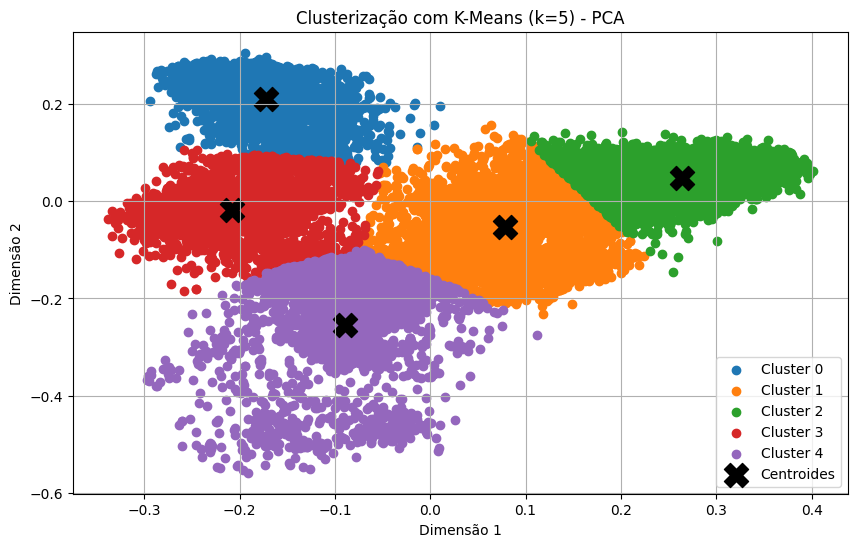

In [20]:
df_portarias_mgi = clusterizar_e_plotar(df_portarias_mgi, 'USE_Embeddings4_PCA', n_clusters=5, sufixo_grafico="PCA")

#### 1.2.3) Redução com t-SNE

In [21]:
resultado_kmeans = processar_kmeans(df_portarias_mgi, 'USE_Embeddings4_TSNE', k_min=2, k_max=10)

# Exibir os resultados
resultado_kmeans.head(100)

,k,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
0,2,0.344817,1.206146,10844.038086
1,3,0.383185,0.862073,14991.856445
2,4,0.355466,0.862448,15297.333984
3,5,0.362651,0.872118,16666.941406
4,6,0.340806,0.962856,15920.303711
5,7,0.347249,0.940793,15751.184570
6,8,0.377628,0.811396,17581.708984
7,9,0.364207,0.856510,16847.449219
8,10,0.370092,0.861296,16977.894531


Dimensões do embeddings: 2

--- Métricas de Avaliação ---
Silhouette Score: 0.3776
Davies-Bouldin Score: 0.8114
Calinski-Harabasz Score: 17581.7090
-----------------------------

Gerando gráfico 2D...


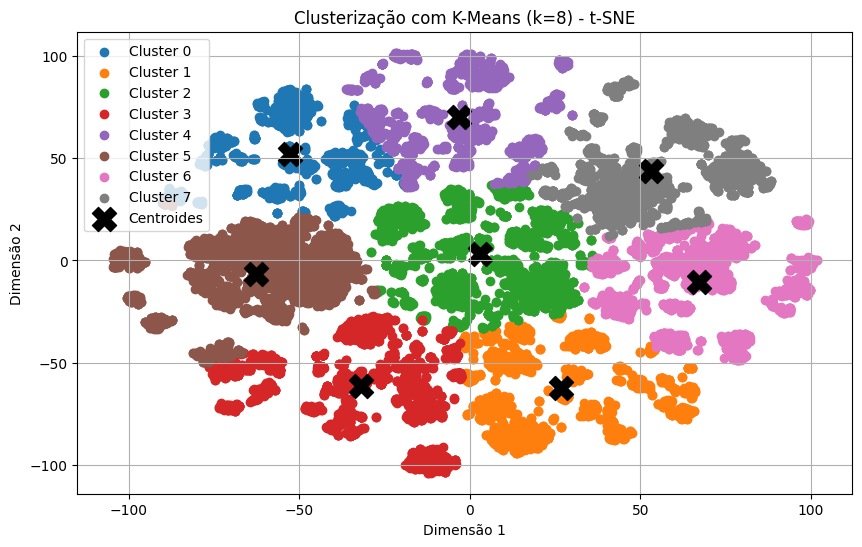

In [22]:
df_portarias_mgi = clusterizar_e_plotar(df_portarias_mgi, 'USE_Embeddings4_TSNE', n_clusters=8, sufixo_grafico="t-SNE")

#### 1.2.4) Redução com PCA + t-SNE

In [23]:
resultado_kmeans = processar_kmeans(df_portarias_mgi, 'USE_Embeddings4_PCA_TSNE', k_min=2, k_max=10)

# Exibir os resultados
resultado_kmeans.head(100)

,k,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
0,2,0.342897,1.217443,10767.424805
1,3,0.365005,0.885532,14136.122070
2,4,0.385362,0.812645,16762.123047
3,5,0.358673,0.870308,16342.530273
4,6,0.339631,0.951770,15607.561523
5,7,0.387623,0.763452,17617.593750
6,8,0.373192,0.843948,16899.072266
7,9,0.368470,0.856449,16396.906250
8,10,0.381382,0.805880,17309.794922


Dimensões do embeddings: 2

--- Métricas de Avaliação ---
Silhouette Score: 0.3876
Davies-Bouldin Score: 0.7635
Calinski-Harabasz Score: 17617.5938
-----------------------------

Gerando gráfico 2D...


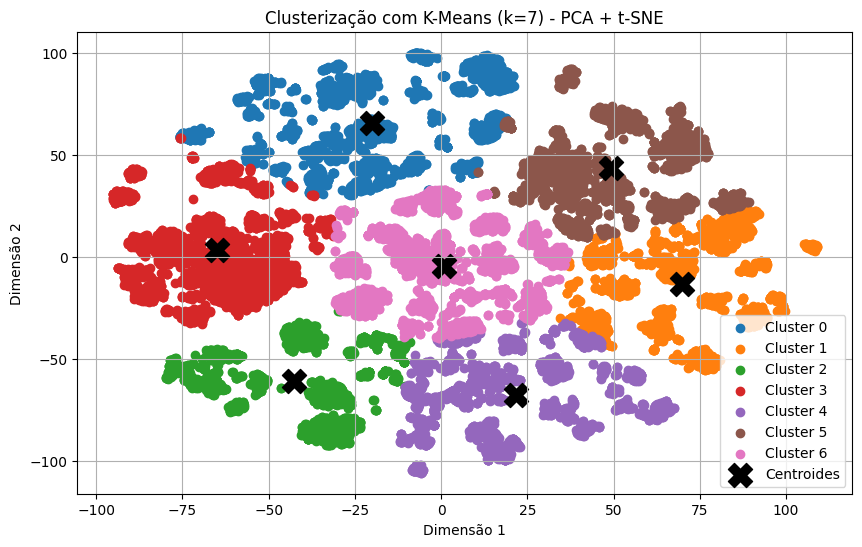

In [24]:
df_portarias_mgi = clusterizar_e_plotar(df_portarias_mgi, 'USE_Embeddings4_PCA_TSNE', n_clusters=7, sufixo_grafico="PCA + t-SNE")

#### 1.2.5) Redução com UMAP

In [25]:
resultado_kmeans = processar_kmeans(df_portarias_mgi, 'USE_Embeddings4_UMAP', k_min=2, k_max=10)

# Exibir os resultados
resultado_kmeans.head(100)

,k,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
0,2,0.418957,0.981526,17050.693359
1,3,0.425990,0.837759,17988.240234
2,4,0.437909,0.785603,20147.490234
3,5,0.455514,0.772349,20950.099609
4,6,0.486800,0.707292,23343.945312
5,7,0.467355,0.756427,23422.191406
6,8,0.460843,0.732403,22653.980469
7,9,0.435218,0.818855,21494.921875
8,10,0.440097,0.812418,21273.523438


Dimensões do embeddings: 2

--- Métricas de Avaliação ---
Silhouette Score: 0.4868
Davies-Bouldin Score: 0.7073
Calinski-Harabasz Score: 23343.9453
-----------------------------

Gerando gráfico 2D...


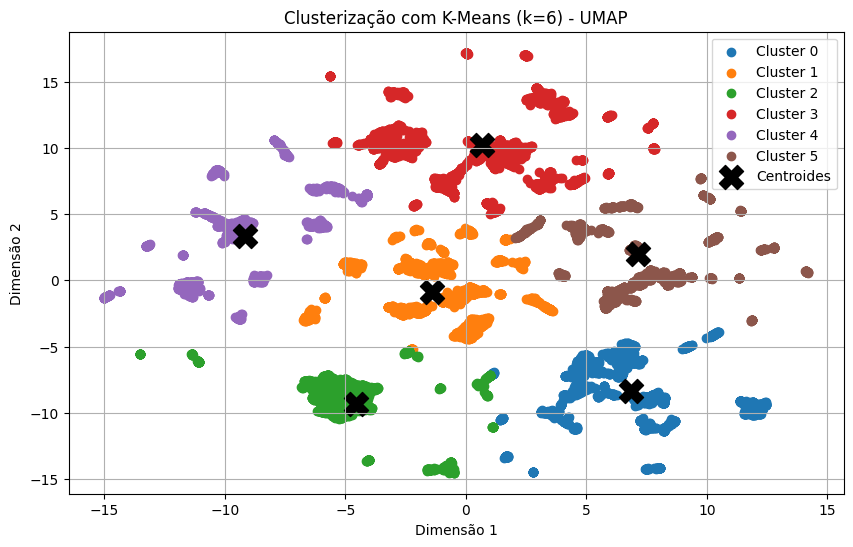

In [26]:
df_portarias_mgi = clusterizar_e_plotar(df_portarias_mgi, 'USE_Embeddings4_UMAP', n_clusters=6, sufixo_grafico="UMAP")

## 2) Embedding Sentence-BERT (SBERT)

###  2.1) Sem tratamento do texto

#### 2.1.1) Sem redução de dimensionalidade

In [27]:
resultado_kmeans = processar_kmeans(df_portarias_mgi, 'SBERT_Embeddings1', k_min=2, k_max=10)

# Exibir os resultados
resultado_kmeans.head(100)

,k,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
0,2,0.108018,2.825460,2271.351318
1,3,0.114440,2.389122,2407.116699
2,4,0.104140,2.492732,1989.008667
3,5,0.101005,2.481007,1753.341675
4,6,0.097903,2.341353,1625.646606
5,7,0.087299,2.264023,1496.017700
6,8,0.089884,2.207795,1417.514771
7,9,0.094960,2.216045,1324.862793
8,10,0.098692,2.239562,1255.716187


Dimensões do embeddings: 768

--- Métricas de Avaliação ---
Silhouette Score: 0.1144
Davies-Bouldin Score: 2.3891
Calinski-Harabasz Score: 2407.1167
-----------------------------

Reduzindo as dimensões para 2 com PCA para visualização (original: 768 dimensões)...
Gerando gráfico 2D...


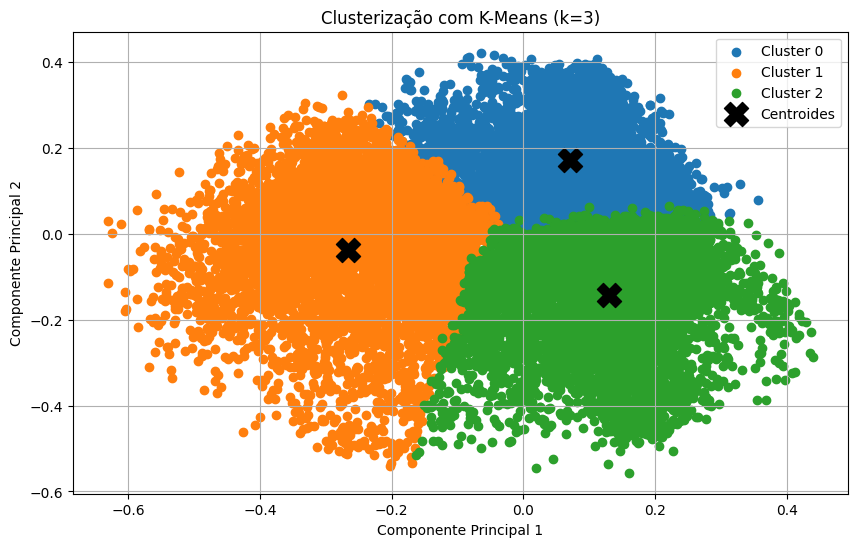

In [28]:
df_portarias_mgi = clusterizar_e_plotar(df_portarias_mgi, 'SBERT_Embeddings1', n_clusters=3)

#### 2.1.2) Redução com PCA

In [29]:
resultado_kmeans = processar_kmeans(df_portarias_mgi, 'SBERT_Embeddings1_PCA', k_min=2, k_max=10)

# Exibir os resultados
resultado_kmeans.head(100)

,k,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
0,2,0.419403,0.992978,12964.755859
1,3,0.430311,0.764567,18652.400391
2,4,0.395344,0.831369,17611.841797
3,5,0.384130,0.906365,17998.181641
4,6,0.388465,0.829332,17989.560547
5,7,0.388561,0.818414,17252.306641
6,8,0.360264,0.858256,17709.123047
7,9,0.339650,0.896966,17215.277344
8,10,0.340453,0.900672,17140.093750


Dimensões do embeddings: 2

--- Métricas de Avaliação ---
Silhouette Score: 0.4303
Davies-Bouldin Score: 0.7646
Calinski-Harabasz Score: 18652.4004
-----------------------------

Gerando gráfico 2D...


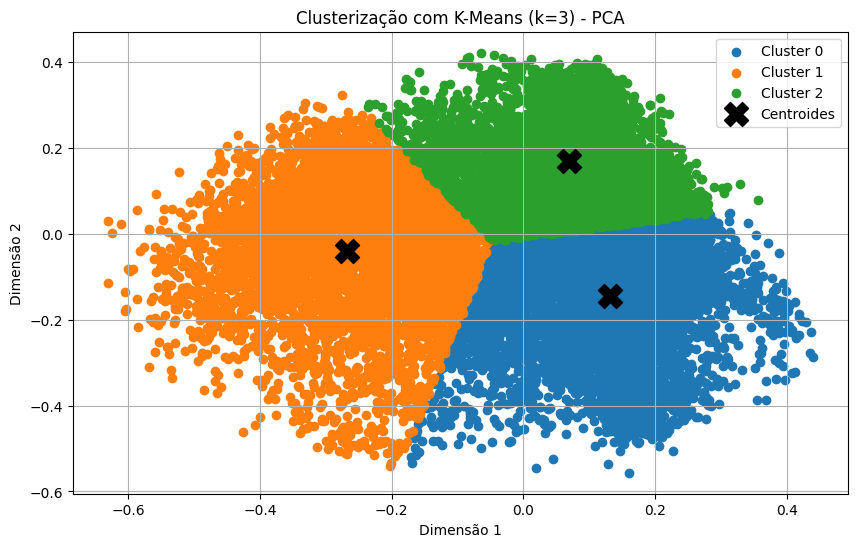

In [30]:
df_portarias_mgi = clusterizar_e_plotar(df_portarias_mgi, 'SBERT_Embeddings1_PCA', n_clusters=3, sufixo_grafico="PCA")

#### 2.1.3) Redução com t-SNE

In [31]:
resultado_kmeans = processar_kmeans(df_portarias_mgi, 'SBERT_Embeddings1_TSNE', k_min=2, k_max=10)

# Exibir os resultados
resultado_kmeans.head(100)

,k,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
0,2,0.355558,1.155863,11760.108398
1,3,0.383723,0.867477,15375.374023
2,4,0.367819,0.845243,16094.522461
3,5,0.356157,0.887144,16137.990234
4,6,0.340508,0.878502,15450.778320
5,7,0.362840,0.869775,16223.971680
6,8,0.363300,0.840182,16394.460938
7,9,0.353786,0.898170,15710.944336
8,10,0.349281,0.843232,15919.841797


Dimensões do embeddings: 2

--- Métricas de Avaliação ---
Silhouette Score: 0.3633
Davies-Bouldin Score: 0.8402
Calinski-Harabasz Score: 16394.4609
-----------------------------

Gerando gráfico 2D...


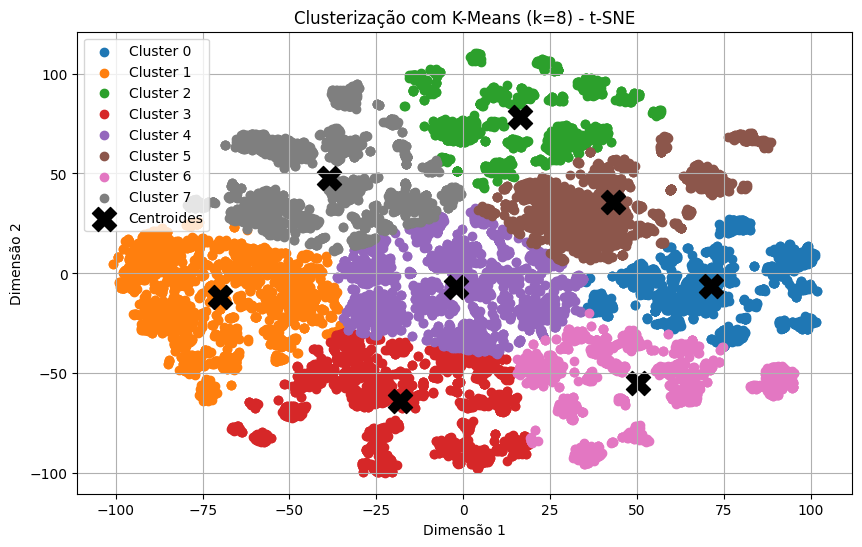

In [32]:
df_portarias_mgi = clusterizar_e_plotar(df_portarias_mgi, 'SBERT_Embeddings1_TSNE', n_clusters=8, sufixo_grafico="t-SNE")

#### 2.1.4) Redução com PCA + t-SNE

In [33]:
resultado_kmeans = processar_kmeans(df_portarias_mgi, 'SBERT_Embeddings1_PCA_TSNE', k_min=2, k_max=10)

# Exibir os resultados
resultado_kmeans.head(100)

,k,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
0,2,0.356042,1.158188,11797.008789
1,3,0.361879,0.911138,13672.551758
2,4,0.364845,0.849775,15934.760742
3,5,0.360268,0.879143,16417.156250
4,6,0.335889,0.955850,15336.892578
5,7,0.376739,0.787573,17160.021484
6,8,0.364202,0.845534,16260.064453
7,9,0.356327,0.835535,16679.988281
8,10,0.351838,0.863634,16069.744141


Dimensões do embeddings: 2

--- Métricas de Avaliação ---
Silhouette Score: 0.3767
Davies-Bouldin Score: 0.7876
Calinski-Harabasz Score: 17160.0215
-----------------------------

Gerando gráfico 2D...


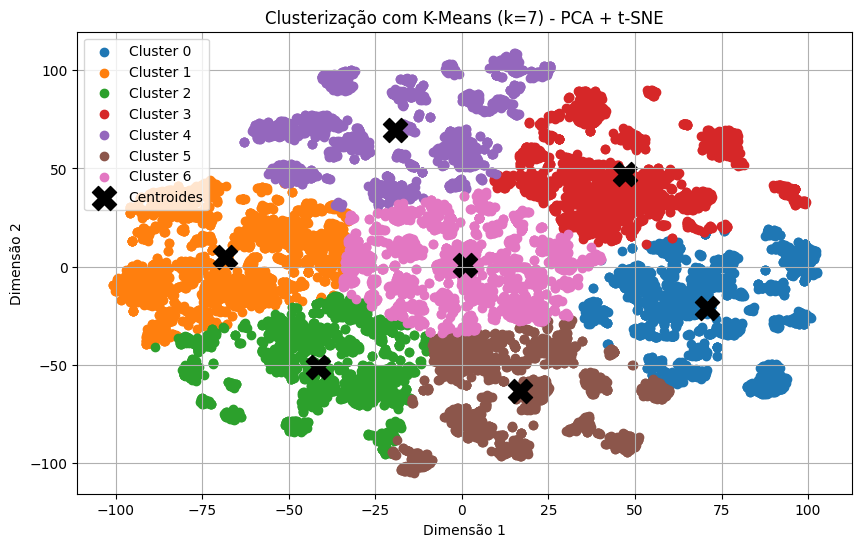

In [34]:
df_portarias_mgi = clusterizar_e_plotar(df_portarias_mgi, 'SBERT_Embeddings1_PCA_TSNE', n_clusters=7, sufixo_grafico="PCA + t-SNE")

#### 2.1.5) Redução com UMAP

In [35]:
resultado_kmeans = processar_kmeans(df_portarias_mgi, 'SBERT_Embeddings1_UMAP', k_min=2, k_max=10)

# Exibir os resultados
resultado_kmeans.head(100)

,k,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
0,2,0.399202,0.988639,14962.783203
1,3,0.406303,0.908048,15019.821289
2,4,0.331167,0.993062,13955.030273
3,5,0.358228,0.941812,14052.296875
4,6,0.378001,0.915274,14571.231445
5,7,0.404364,0.816004,14967.954102
6,8,0.420374,0.856472,15522.116211
7,9,0.440798,0.785442,15473.456055
8,10,0.454379,0.722698,17293.222656


Dimensões do embeddings: 2

--- Métricas de Avaliação ---
Silhouette Score: 0.4544
Davies-Bouldin Score: 0.7227
Calinski-Harabasz Score: 17293.2227
-----------------------------

Gerando gráfico 2D...


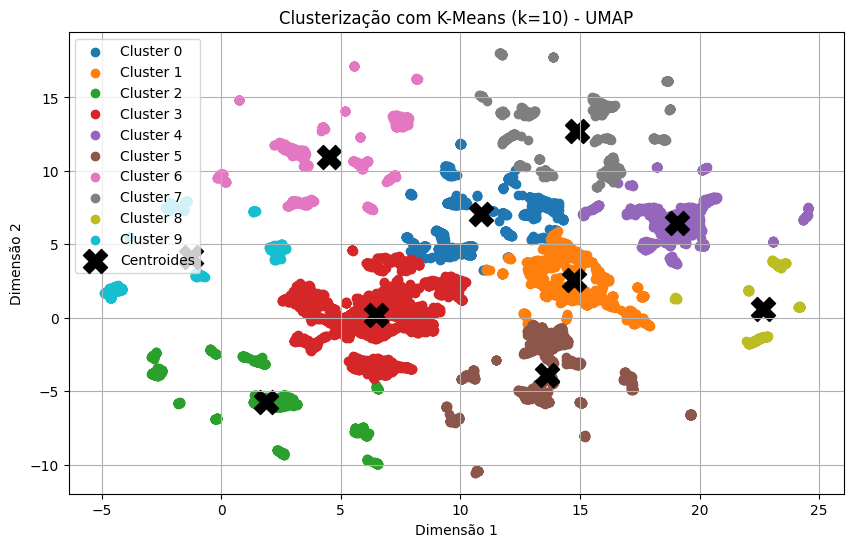

In [36]:
df_portarias_mgi = clusterizar_e_plotar(df_portarias_mgi, 'SBERT_Embeddings1_UMAP', n_clusters=10, sufixo_grafico="UMAP")

###  2.2) Com tratamento do texto

#### 2.2.1) Sem redução de dimensionalidade

In [37]:
resultado_kmeans = processar_kmeans(df_portarias_mgi, 'SBERT_Embeddings4', k_min=2, k_max=10)

# Exibir os resultados
resultado_kmeans.head(100)

,k,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
0,2,0.169226,2.153127,3911.534424
1,3,0.148525,2.542603,2751.219727
2,4,0.117821,2.752147,2123.070801
3,5,0.100587,2.542162,2001.897949
4,6,0.099036,2.392062,1801.683838
5,7,0.103973,2.343997,1603.720459
6,8,0.099620,2.253318,1544.152100
7,9,0.100772,2.383432,1428.519775
8,10,0.096145,2.291930,1326.098999


Dimensões do embeddings: 768

--- Métricas de Avaliação ---
Silhouette Score: 0.1692
Davies-Bouldin Score: 2.1531
Calinski-Harabasz Score: 3911.5344
-----------------------------

Reduzindo as dimensões para 2 com PCA para visualização (original: 768 dimensões)...
Gerando gráfico 2D...


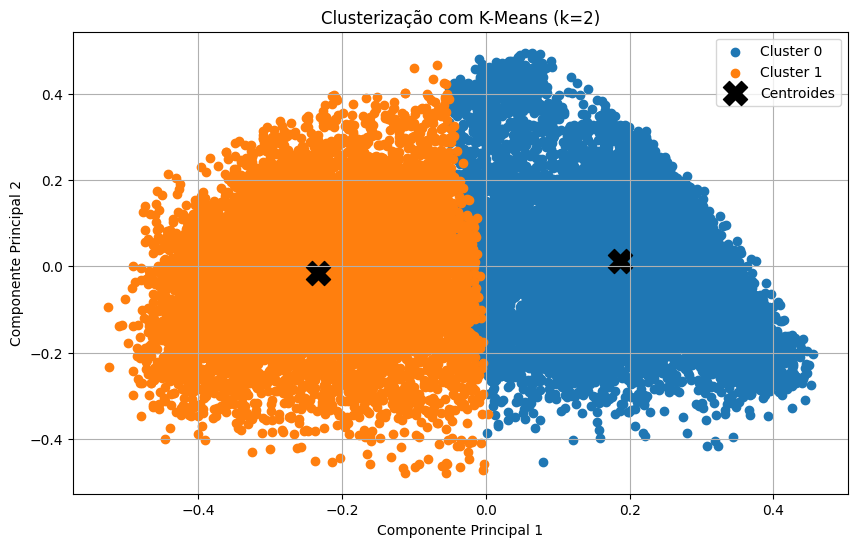

In [38]:
df_portarias_mgi = clusterizar_e_plotar(df_portarias_mgi, 'SBERT_Embeddings4', n_clusters=2)

#### 2.2.2) Redução com PCA

In [39]:
resultado_kmeans = processar_kmeans(df_portarias_mgi, 'SBERT_Embeddings4_PCA', k_min=2, k_max=10)

# Exibir os resultados
resultado_kmeans.head(100)

,k,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
0,2,0.474514,0.825463,21820.386719
1,3,0.427372,0.856482,20846.242188
2,4,0.382383,0.897540,18499.341797
3,5,0.376070,0.831106,19220.335938
4,6,0.372152,0.830828,19966.730469
5,7,0.365113,0.855678,19248.265625
6,8,0.330486,0.892741,18925.638672
7,9,0.344608,0.885340,19459.978516
8,10,0.358021,0.806167,19822.345703


Dimensões do embeddings: 2

--- Métricas de Avaliação ---
Silhouette Score: 0.4745
Davies-Bouldin Score: 0.8255
Calinski-Harabasz Score: 21820.3867
-----------------------------

Gerando gráfico 2D...


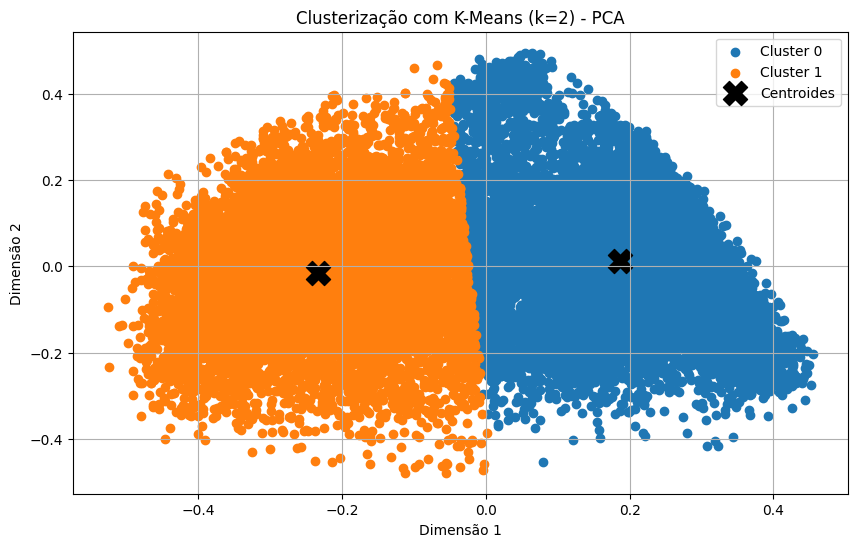

In [40]:
df_portarias_mgi = clusterizar_e_plotar(df_portarias_mgi, 'SBERT_Embeddings4_PCA', n_clusters=2, sufixo_grafico="PCA")

#### 2.2.3) Redução com t-SNE

In [41]:
resultado_kmeans = processar_kmeans(df_portarias_mgi, 'SBERT_Embeddings4_TSNE', k_min=2, k_max=10)

# Exibir os resultados
resultado_kmeans.head(100)

,k,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
0,2,0.353587,1.166625,11669.846680
1,3,0.376351,0.872884,14751.354492
2,4,0.360772,0.863605,15633.075195
3,5,0.351297,0.873555,15984.635742
4,6,0.381027,0.774638,16464.478516
5,7,0.383316,0.769631,17450.765625
6,8,0.358494,0.820746,16687.373047
7,9,0.352086,0.858278,16814.820312
8,10,0.337258,0.897940,16441.267578


Dimensões do embeddings: 2

--- Métricas de Avaliação ---
Silhouette Score: 0.3833
Davies-Bouldin Score: 0.7696
Calinski-Harabasz Score: 17450.7656
-----------------------------

Gerando gráfico 2D...


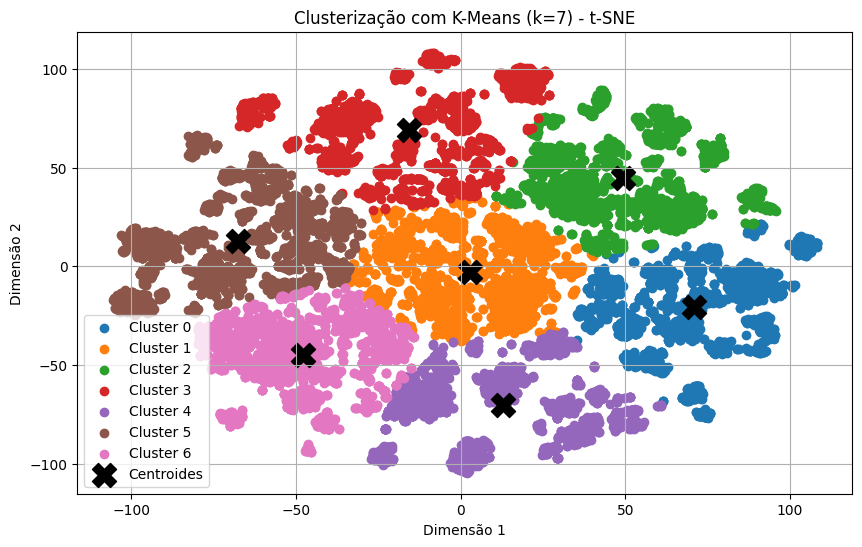

In [42]:
df_portarias_mgi = clusterizar_e_plotar(df_portarias_mgi, 'SBERT_Embeddings4_TSNE', n_clusters=7, sufixo_grafico="t-SNE")

#### 2.2.4) Redução com PCA + t-SNE

In [43]:
resultado_kmeans = processar_kmeans(df_portarias_mgi, 'SBERT_Embeddings4_PCA_TSNE', k_min=2, k_max=10)

# Exibir os resultados
resultado_kmeans.head(100)

,k,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
0,2,0.351055,1.178028,11440.026367
1,3,0.376577,0.865106,14704.941406
2,4,0.363793,0.852949,15879.146484
3,5,0.349156,0.880775,15923.108398
4,6,0.380789,0.806382,16621.998047
5,7,0.387399,0.768491,17616.240234
6,8,0.360115,0.819664,16935.423828
7,9,0.346898,0.840833,16259.169922
8,10,0.357153,0.858831,16875.230469


Dimensões do embeddings: 2

--- Métricas de Avaliação ---
Silhouette Score: 0.3874
Davies-Bouldin Score: 0.7685
Calinski-Harabasz Score: 17616.2402
-----------------------------

Gerando gráfico 2D...


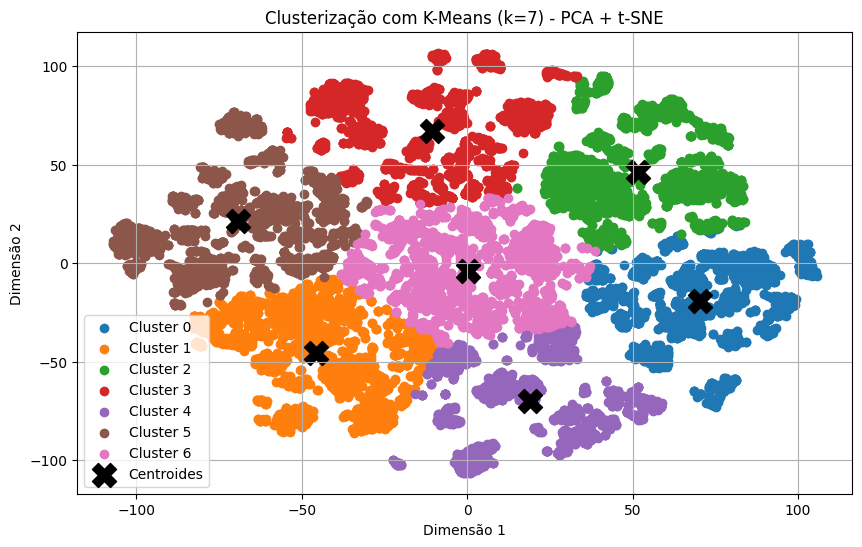

In [44]:
df_portarias_mgi = clusterizar_e_plotar(df_portarias_mgi, 'SBERT_Embeddings4_PCA_TSNE', n_clusters=7, sufixo_grafico="PCA + t-SNE")

#### 2.2.5) Redução com UMAP

In [45]:
resultado_kmeans = processar_kmeans(df_portarias_mgi, 'SBERT_Embeddings4_UMAP', k_min=2, k_max=10)

# Exibir os resultados
resultado_kmeans.head(100)

,k,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
0,2,0.427924,0.932576,17493.570312
1,3,0.443510,0.856409,19307.050781
2,4,0.436403,0.825109,19583.195312
3,5,0.436184,0.804693,19465.164062
4,6,0.449313,0.741439,18642.929688
5,7,0.428219,0.794458,19470.345703
6,8,0.447045,0.817047,19898.314453
7,9,0.440622,0.822024,20396.046875
8,10,0.464185,0.739675,22729.589844


Dimensões do embeddings: 2

--- Métricas de Avaliação ---
Silhouette Score: 0.4642
Davies-Bouldin Score: 0.7397
Calinski-Harabasz Score: 22729.5898
-----------------------------

Gerando gráfico 2D...


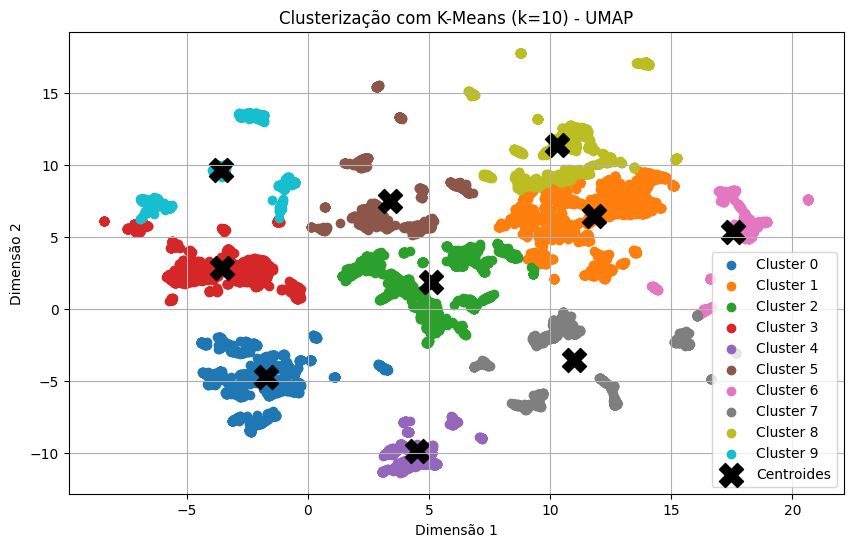

In [46]:
df_portarias_mgi = clusterizar_e_plotar(df_portarias_mgi, 'SBERT_Embeddings4_UMAP', n_clusters=10, sufixo_grafico="UMAP")